In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from botorch.test_functions import SyntheticTestFunction

import sys
# sys.path.append('..')
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')

from low_rank_BOPE.bope_class_retraining import RetrainingBopeExperiment

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load saved data (control params, trajectory) and train a decision tree regressor

In [2]:
# path of data
data_path = "/home/yz685/low_rank_BOPE/experiments/robot_data/3_50_1"

In [10]:
import os

data_files = os.listdir(data_path)

In [13]:
train_X = torch.tensor([])
train_Y = torch.tensor([])

In [15]:
for data_name in data_files:
    if data_name.startswith("n=2000"):
        print(data_name)
        data = torch.load(os.path.join(data_path, data_name))
        train_X = torch.cat((train_X, torch.tensor(data['X'])))
        train_Y = torch.cat((train_Y, torch.tensor(data['Y'])))
        print(train_X.shape, train_Y.shape)

n=2000_seed=20.pt
torch.Size([2000, 3]) torch.Size([2000, 150])
n=2000_seed=16.pt
torch.Size([4000, 3]) torch.Size([4000, 150])
n=2000_seed=3.pt
torch.Size([6000, 3]) torch.Size([6000, 150])
n=2000_seed=5.pt
torch.Size([8000, 3]) torch.Size([8000, 150])
n=2000_seed=4.pt


/tmp/ipykernel_1427257/3541311555.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = torch.cat((train_X, torch.tensor(data['X'])))
/tmp/ipykernel_1427257/3541311555.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_Y = torch.cat((train_Y, torch.tensor(data['Y'])))


torch.Size([10000, 3]) torch.Size([10000, 150])
n=2000_seed=2.pt
torch.Size([12000, 3]) torch.Size([12000, 150])
n=2000_seed=11.pt
torch.Size([14000, 3]) torch.Size([14000, 150])
n=2000_seed=13.pt
torch.Size([16000, 3]) torch.Size([16000, 150])
n=2000_seed=19.pt
torch.Size([18000, 3]) torch.Size([18000, 150])
n=2000_seed=12.pt
torch.Size([20000, 3]) torch.Size([20000, 150])
n=2000_seed=9.pt
torch.Size([22000, 3]) torch.Size([22000, 150])
n=2000_seed=7.pt
torch.Size([24000, 3]) torch.Size([24000, 150])
n=2000_seed=18.pt
torch.Size([26000, 3]) torch.Size([26000, 150])
n=2000_seed=15.pt
torch.Size([28000, 3]) torch.Size([28000, 150])
n=2000_seed=10.pt
torch.Size([30000, 3]) torch.Size([30000, 150])
n=2000_seed=17.pt
torch.Size([32000, 3]) torch.Size([32000, 150])
n=2000_seed=6.pt
torch.Size([34000, 3]) torch.Size([34000, 150])
n=2000_seed=8.pt
torch.Size([36000, 3]) torch.Size([36000, 150])
n=2000_seed=14.pt
torch.Size([38000, 3]) torch.Size([38000, 150])
n=2000_seed=1.pt
torch.Size([4000

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


In [28]:
reg_dt = DecisionTreeRegressor()
reg_dt.fit(train_X.numpy(), train_Y.numpy())

DecisionTreeRegressor()

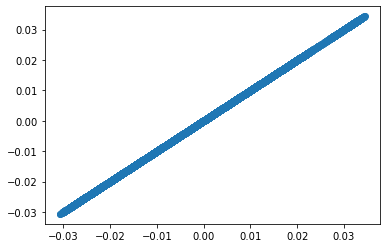

In [31]:
plt.scatter(train_Y[:,70].numpy(), reg_dt.predict(train_X.numpy())[:,70])

In [ ]:
# TODO: cross validation and hyperparameter tuning

## Construct an outcome function class that uses the surrogate model

In [32]:
from low_rank_BOPE.test_problems.robot.robot import SpotMiniMiniProblem, RobotUtil

problem = SpotMiniMiniProblem()
util_func = RobotUtil()

/home/yz685/low_rank_BOPE/low_rank_BOPE/aux_software/spot_mini_mini/spotmicro/util/pybullet_data


pybullet build time: May 20 2022 19:45:31


In [34]:
from typing import Optional

class SpotMiniMiniProblemSurrogate(SyntheticTestFunction):

    param_names = ["SwingPeriod", "StepVelocity", "ClearanceHeight", "roll", "pitch"]
    pi8 = np.pi / 8
    original_bounds = torch.tensor(
        [
            [0.1, 0.001, 0, -pi8, -pi8],
            [0.4, 3, 0.1, pi8, pi8],
        ]
    )
    noise_std = 0.0

    def __init__(
        self, 
        model: object,
        dim: int = 3,
        max_timesteps: int = 50,
        record_pos_every_n: int = 5,
        noise_std: Optional[float] = None,
        negate: bool = False,
    ):

        """
        Args:
            model: a trained sklearn model, surrogate for the original robot trajectory simulator
        """

        self.dim=dim
        if dim > 5: 
            raise ValueError("dim should be <= 5!")
        self._bounds = [(0., 1.) for _ in range(dim)]
        super().__init__(noise_std=noise_std, negate=negate)

        self.max_timesteps = max_timesteps
        self.record_pos_every_n = record_pos_every_n
        self.outcome_dim = max_timesteps // record_pos_every_n * 3

        self.surr_model = model
    
    def evaluate_true(self, X: Tensor) -> Tensor:

        X_ = self._unstandardize_X(X, bounds = self.original_bounds[:, :self.dim].clone().detach())

        return torch.tensor(self.surr_model.predict(X_.numpy()))
    
    
    def _unstandardize_X(self, X, bounds):
            
        r"""
        Unstandardize the input X in [0,1] to the original bounds.

        Args:
            X: `num_samples x dim` tensor of inputs
            bounds: `2 x dim` tensor of bounds

        Returns:
            X: `num_samples x dim` tensor of unstandardized inputs
        """
        return X * (bounds[1] - bounds[0]) + bounds[0]



In [35]:
outcome_func = SpotMiniMiniProblemSurrogate(model=reg_dt, dim=3, max_timesteps=50, record_pos_every_n=1, noise_std=0.0, negate=False)

In [36]:
outcome_func(train_X[:10])

tensor([[-6.5725e-05, -8.1066e-05, -5.4261e-05,  ...,  1.9768e-01,
          1.9694e-01,  1.9586e-01],
        [-7.7914e-05, -1.0927e-04, -1.0210e-04,  ...,  2.0440e-01,
          2.0457e-01,  2.0497e-01],
        [-4.6706e-05, -5.4147e-05, -3.1083e-05,  ...,  1.9324e-01,
          1.9270e-01,  1.9350e-01],
        ...,
        [-5.4230e-05, -6.5295e-05, -4.3106e-05,  ...,  1.9467e-01,
          1.9502e-01,  1.9517e-01],
        [-5.4061e-05, -7.0797e-05, -5.8541e-05,  ...,  1.9943e-01,
          2.0043e-01,  2.0104e-01],
        [-5.2513e-05, -6.6400e-05, -4.8088e-05,  ...,  1.9452e-01,
          1.9359e-01,  1.9414e-01]], dtype=torch.float64)

## Test that the surrogate-model based outcome function fits within the BOPE experiment framework

In [40]:
from low_rank_BOPE.bope_class_retraining import RetrainingBopeExperiment

problem = SpotMiniMiniProblemSurrogate(model=reg_dt, dim=3, max_timesteps=50, record_pos_every_n=1, noise_std=0.0, negate=False)

util_func = RobotUtil()

methods = [
    # "pca", # unweighted PCA
    "pca_rt",
    # "pca_norefit_rt",
    # "pca_all_rt", # unweighted PCA with retraining
    # "pca_eubo_rt",
    # "pca_postmax_rt",
    # "wpca_true_rt", # PCA with true-util-value based rank weights
    # "wpca_est_rt",
    # "spca_true_rt",
    # "spca_est_rt",
    # "st", # indep GP
    # "random_linear_proj",
    # "random_subset",
    # "random_search",
    # "pbo"
]

exp = RetrainingBopeExperiment(
    problem = problem,
    util_func=util_func,
    methods=methods,
    # pe_strategies = ["EUBO-zeta"],
    pe_strategies = {
        "pca_rt": ["EUBO-zeta"], 
        # "pbo": ["TS", "EUBO-zeta"],
        # "random_search": ["EUBO-zeta"]
    },
    trial_idx=324,
    output_path="dummy",
    n_check_post_mean = 3,
    every_n_comps = 2,
    initial_experimentation_batch = 16,
    pca_var_threshold = 0.9,
    n_BO_iters = 1,
    standardize = False, # don't standardize for shapes!
    include_xp1_candidates = True, 
    BO_batch_size = 4,
    n_meta_iters = 2, # test interactive
    save_results=False
)

In [41]:
exp.generate_random_experiment_data(16)

In [42]:
exp.run_BOPE_loop()

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz68